In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import netCDF4 as ncd
import xarray as xr
import cartopy.crs as ccrs
import cartopy as cart
import harmonica as hm
from scipy import interpolate
#import metpy.calc as mpcalc


print('Hello Storms!')

Hello Storms!


In [75]:
# Defining parameters

#=====================
# years to be analysed
anoi=1979
anof=2006


#============
# Half of a box to search a local pressure minima. This is draw around each grid point within the analyse domain
delx_box=4
dely_box=4


#============
# Half of ciclone length. Usutally we observe a box of 10x10 degrees fitting quite well
delx_cy=4
dely_cy=4


#=========
# Minimum pressure drop to be a cyclone candidate
delP_min=400.0  #[Pa]
delVort_min=-1.5e-5

Pressure=True  # True or False, enable or disable detection from pressure criteria
Vorticity=True # True or False, enable or disable detection from vorticity criteria
#=========================================================
# Area of interest. These are index of lon and lat arrays.
#
#        lat_end ---+________+---
#                   |        |
#                   |        |
#                   |        |
#      lat_start ---+________+---
#                   |        |
#            lon_start      lon_end
#
# 
lon_start=-61
lon_end=-39
lat_start=-43
lat_end=-24

# Here we find the index of Lat and Lon arrays for those values defined above
def grid_offset():
    ixi=min(range(len(lon)), key=lambda i: abs(lon[i]-lon_start)) # find index of longitude nereast to 69W
    ixf=min(range(len(lon)), key=lambda i: abs(lon[i]-lon_end)) # find index of longitude nereast to 35W
    jyi=min(range(len(lat)), key=lambda i: abs(lat[i]-lat_start)) # find index of latitude nereast to 54S
    jyf=min(range(len(lat)), key=lambda i: abs(lat[i]-lat_end)) # find index of latitude nereast to 20S
    return ixi,ixf,jyi,jyf

    

In [76]:
# Here there are many functions that open, read, calculate something ....

# Load the topography file
data = hm.datasets.fetch_topography_earth()


# Reads sea level pressure add vorticity
def openc_getvar():
    pnc= xr.open_dataset('vort/mslp.'+str(ano)+'.nc')
    vnc= xr.open_dataset('vort/vort.'+str(ano)+'.nc')
    vort=np.squeeze(vnc['VORT'][:], axis=1)#[jyi:jyf]    
    slp=pnc['mslp'][:]#[it,jyi:jyf,ixi:ixf]
    return slp,vort


# Get X and Y axis coordinates
def openc_getCoord():
    nc= xr.open_dataset('vort/mslp.'+str(ano)+'.nc')
    lat=nc.coords['lat']#[jyi:jyf]
    lons=nc.coords['lon']#[ixi:ixf]
    lon=np.empty(len(lons))
    lon[0:72]=lons[72:144]-360
    lon[72:144]=lons[0:72]
    return lat,lon
  

# Reanalysis I and II from NOAA/NCEP start at Lon=0 and go untill 360. 
# Here I adjust them to start at Lon=-180, so the South Atlantic is centered. Thats not necessary, but I like it better this way...
def adjustgrid(key):
    if key == 'p':
        var2=np.empty([len(slp),len(lat),len(lon)])
        var2[:,:,0:72]=slp[:,:,72:144]
        var2[:,:,72:144]=slp[:,:,0:72]
    elif key == 'v':
        var2=np.empty([len(vort),len(lat),len(lon)])
        var2[:,:,0:72]=vort[:,:,72:144]
        var2[:,:,72:144]=vort[:,:,0:72]
    return var2
        
    

In [68]:
# Find a local SLP minima and returns its i,j index position 
def achaPmin(ic,jc):
    minimum=np.min(np.array(slp2[day,jc-dely_box:jc+dely_box+1,ic-delx_box:ic+delx_box+1]))
    jmin,imin = np.where(np.array(slp2[day,jc-dely_box:jc+dely_box+1,ic-delx_box:ic+delx_box+1]) == minimum)
    return int(imin[0]+ic-delx_box),int(jmin[0]+jc-dely_box)

# Finds local vorticity minima and returns (i,j) index position 
def achaVmin(ic,jc):
    minimum=np.min(np.array(vort2[day,jc-dely_box:jc+dely_box+1,ic-delx_box:ic+delx_box+1]))
    jmin,imin = np.where(np.array(vort2[day,jc-dely_box:jc+dely_box+1,ic-delx_box:ic+delx_box+1]) == minimum)
    return int(imin[0]+ic-delx_box),int(jmin[0]+jc-dely_box)


# Here SLP(day,jmin,imin) is tested against its neighbors.
# If it reaches > 5hPa, it is marked as a cyclone candidate.
def testp(imin,jmin):
    isP=False
    im2,jm2=achaPmin(imin,jmin)
    if im2==imin and jm2 ==jmin:
        pc=slp2[day,jmin,imin]
        pb=(slp2[day,jmin-dely_cy,imin-1:imin+2].mean() + slp2[day,jmin+dely_cy,imin-1:imin+2].mean()+
        slp2[day,jmin-1:jmin+2,imin-delx_cy].mean() + slp2[day,jmin-1:jmin+2,imin+delx_cy].mean())/4
        delp=pb-pc
        if float(delp) > delP_min :
            isP=True
    return isP

# Here vorticity(day,jmin,imin) is tested against its neighbors.
# If it is less than a predifined threshold, it is marked as a cyclone candidate.
def testv(imin,jmin):
    isV=False
    im2,jm2=achaVmin(imin,jmin)
    if im2==imin and jm2 ==jmin:
        if vort2[day,jmin,imin] <= delVort_min :
            isV=True
    return isV

# Here I check whether it is a new cyclone or it was already there in the previous time step
def isnew(imin,jmin):
    if cymap[day-1,jmin-dely_box:jmin+dely_box+1,imin-delx_box:imin+delx_box+1].sum() > 0:
        return False
    else:
        return True
        
        

In [69]:
# Lets interpolate topography to our grid.
# We use this to eliminate cyclones over land. Although they do exist, that 
# won't hurt our statistics.
def masktopo():
    f = interpolate.interp2d(data.longitude, data.latitude[::-1], data.topography, kind='cubic')
    mmask=f(lon,lat)
    return mmask


# Function to find the time-step at the beggining and end of each month
def daysj(mes,key):
    if (ano % 4) == 0:
        if (ano % 100) == 0:
            if (ano % 400) == 0:
                feb=29
            else:
                feb=28
        else:
            feb=29
    else:
        feb=28

    dmes=np.array([0,31,feb,31,30,31,30,31,31,30,31,30,31])
    dia1=dmes[0:mes].sum()*4+1
    dia2=dmes[0:mes+1].sum()*4
    if key == 1:
        return dia1
    else:
        return dia2


In [70]:
# Lets load one file to set up a few arrays;
ano=anoi 
lat,lon=openc_getCoord()
slp,vort=openc_getvar()

mmask=masktopo()
mapall=np.zeros([len(range(anoi,anof)),12,len(lat),len(lon)])
#===============================

ixi,ixf,jyi,jyf=grid_offset()
print(ixi,ixf,jyi,jyf)

48 56 53 46


In [71]:
# There it is! The main loop
# IT goes through years, days and LATxLON domain.
# It saves a binary matrix of 0 (nothing) and 1 (cyclone candidate).
for ano in range(anoi,anof,1):
    print('Vou abrir ano %i'%ano)
    slp,vort=openc_getvar()
    slp2=adjustgrid('p')
    vort2=adjustgrid('v')

    cymap=np.zeros(np.shape(slp))
    ciclogenese=np.zeros(np.shape(slp))
    
    for day in range(0,len(slp),1):
        for ix in range(min(ixi,ixf),max(ixi,ixf),1):  # A detecção ocorre num domínio menor, definido por ixi,ixf,jyi,jyf
            for iy in range(min(jyi,jyf),max(jyi,jyf),1):
                iminp,jminp=achaPmin(ix,iy)
                iminv,jminv=achaVmin(ix,iy)
                isp=False
                isv=False
                if cymap[day,jminp,iminp] == 0 and mmask[jminp,iminp] < 0:
                         isp=testp(iminp,jminp)  
                if cymap[day,jminv,iminv] == 0 and mmask[jminv,iminv] < 0:
                         isv=testv(iminv,jminv)  
                
                if isp == True and isv == False :
#                    print('isp=True and isv=False')
                    jp=jminp
                    ip=iminp
                elif isp == False and isv == True :
#                    print('isp=False and isv=True')
                    jp=jminv
                    ip=iminv
                elif isp == True and isv == True:
#                    print('isp=True and isv=True')
                    jp=int((jminv+jminp)/2)
                    ip=int((iminv+iminp)/2)

                    
                if isp == True or isv == True:
                    cymap[day,jp,ip]=1
                    if isnew(ip,jp)== True :
                        ciclogenese[day,jp-1:jp+2,ip-1:ip+2]=1
                        
# Here we organize the output by adding a collum "months"
    for mes in range(1,13):
        mapall[ano-anoi,mes-1,::]+=ciclogenese[daysj(mes,1):daysj(mes,2)+1,::].sum(axis=0)
    
print('Done')


Vou abrir ano 1979
Vou abrir ano 1980
Vou abrir ano 1981
Vou abrir ano 1982
Vou abrir ano 1983
Vou abrir ano 1984
Vou abrir ano 1985
Vou abrir ano 1986
Vou abrir ano 1987
Vou abrir ano 1988
Vou abrir ano 1989
Vou abrir ano 1990
Vou abrir ano 1991
Vou abrir ano 1992
Vou abrir ano 1993
Vou abrir ano 1994
Vou abrir ano 1995
Vou abrir ano 1996
Vou abrir ano 1997
Vou abrir ano 1998
Vou abrir ano 1999
Vou abrir ano 2000
Vou abrir ano 2001
Vou abrir ano 2002
Vou abrir ano 2003
Vou abrir ano 2004
Vou abrir ano 2005
Done


In [85]:
# Save results to use later.
#print(np.shape(mapall),len(mapall))
mmensal=mapall.sum(axis=0)#/len(mapall)
manual=mapall.sum(axis=1)#/len(mmensal)
mall=manual.sum(axis=0)#/len(manual)
np.save('ciclogene_PV_ncep2_1979-2005.npy', mapall)



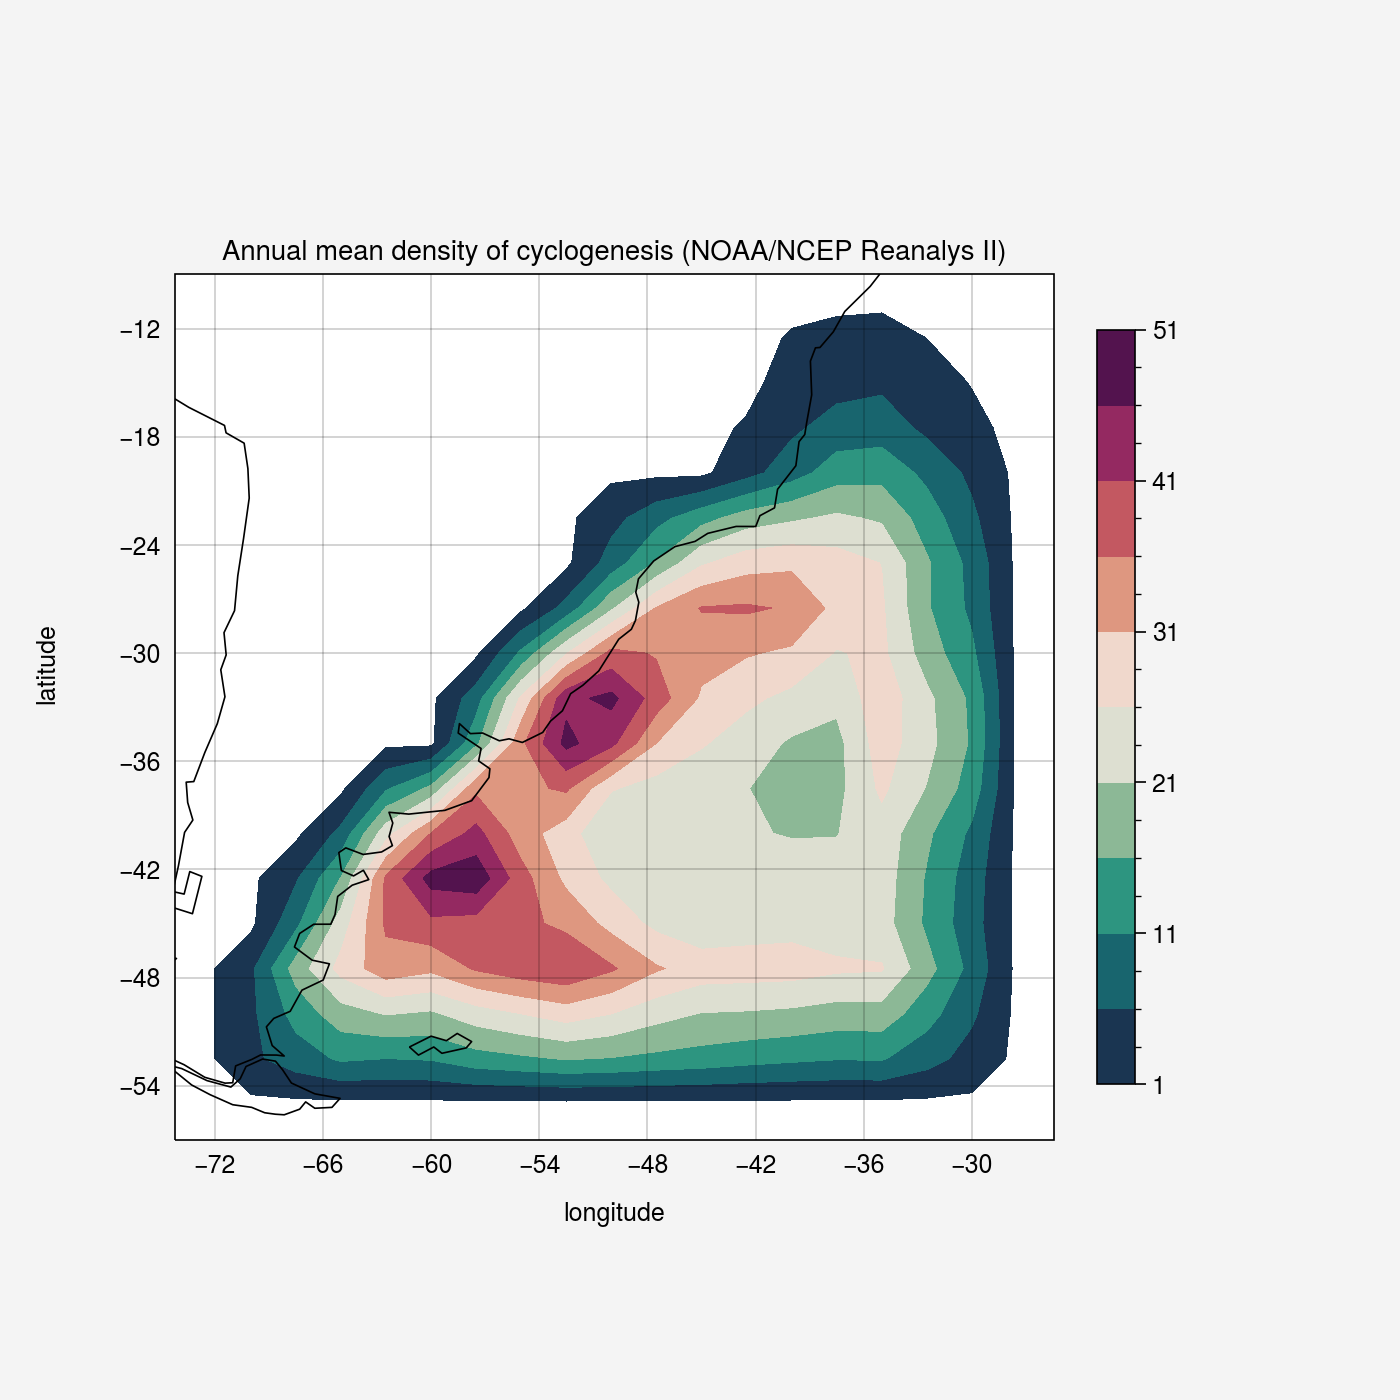

In [95]:
import typhon
import proplot as plot2
levs=range(1,56,5)
fig, ax1= plt.subplots(nrows=1, ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},figsize=(7,7))
cs=ax1.contourf(lon,lat,mapall.sum(axis=(0,1))/len(mapall),levels=levs,transform=ccrs.PlateCarree(),cmap='vorticity') #'PuOr')
ax1.coastlines()
#ax1.add_feature(cart.feature.LAND, zorder=100,edgecolor='k')
ax1.set_title('Annual mean density of cyclogenesis (NOAA/NCEP Reanalys II)')
ax1.text(-0.13, 0.55, 'latitude', va='bottom', ha='center',rotation='vertical', rotation_mode='anchor',transform=ax1.transAxes)
ax1.text(0.5, -0.1, 'longitude', va='bottom', ha='center',rotation='horizontal', rotation_mode='anchor',transform=ax1.transAxes)
gl = ax1.gridlines(draw_labels = True,alpha=0.2) # label all axes
gl.xlabels_top = False #turn off top label
gl.ylabels_right = False #turn off right label


cbar = fig.colorbar(cs, ax=ax1, shrink=0.7, pad=0.04)

In [94]:
# Here we see three regions where cyclogenesis is most likely to occur

print('Thats all folks')


Thats all folks
